# Multi label toxic comments classification with DistilBERT uncased base model

## Goal
* **Goal of a project :** Fine-tune the DistilBert uncased base model for multi-label classification. This model will be used to analyze the Jigsaw Toxic Comment Classification dataset, enabling the detection of multiple toxic content categories within a single comment.
* **Goal of this notebook :** Check which DistilBert model work's better, cased or uncased.

## Evaluation metrics
* **Main metric:** Weighted Roc_auc
* **Secondary metrics:** Weighted F1-score and hamming loss 

## Dataset 
* **Dataset :**  Jigsaw Toxic Comment Classification Challenge dataset https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
* **Description :**   Contains text comments labeled with multiple toxicity categories("toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate").

## Data read

In [1]:
import pandas as pd
import numpy as np

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [2]:
import random
import matplotlib.pyplot as plt
import transformers
import datasets
import torch
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
import torch.nn as nn
np.object = object
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay,roc_auc_score, f1_score, hamming_loss
from sklearn.utils.multiclass import unique_labels
from transformers import TrainingArguments,AutoTokenizer, AutoModelForSequenceClassification,Trainer,EvalPrediction,DistilBertTokenizer , DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import Dataset,DatasetDict
import numpy as np



2024-05-07 12:14:14.454501: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 12:14:14.454603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 12:14:14.556949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
input_files = [
    "/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip",
    "/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip",
    "/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip",
    "/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip",
]

output_directory = "/kaggle/working/extracted_files"


os.makedirs(output_directory, exist_ok=True)

for input_file in input_files:
    !unzip -q {input_file} -d {output_directory}

In [4]:
df_train = pd.read_csv(r'/kaggle/working/extracted_files/train.csv')

In [5]:
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


## Dataset info

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [8]:
df_train.isna().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
labels           False
dtype: bool

* Dataset is made out of 159571 records.
* No missing values found.

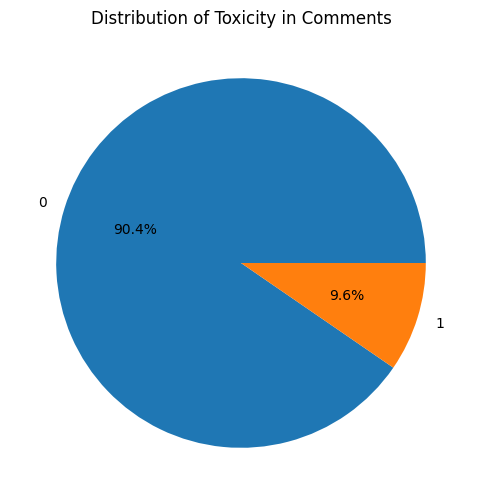

In [11]:
toxic_counts = df_train['toxic'].value_counts().sort_values(ascending=False)

# Create the pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size as desired
plt.pie(toxic_counts, labels=toxic_counts.index, autopct="%1.1f%%")  # Format percentages with one decimal place
plt.title("Distribution of Toxicity in Comments")
plt.show()

* Inbalance: Only 9.6% of values belong to the minority class.

### Distribution of characters amount in comment texts

<Axes: ylabel='Frequency'>

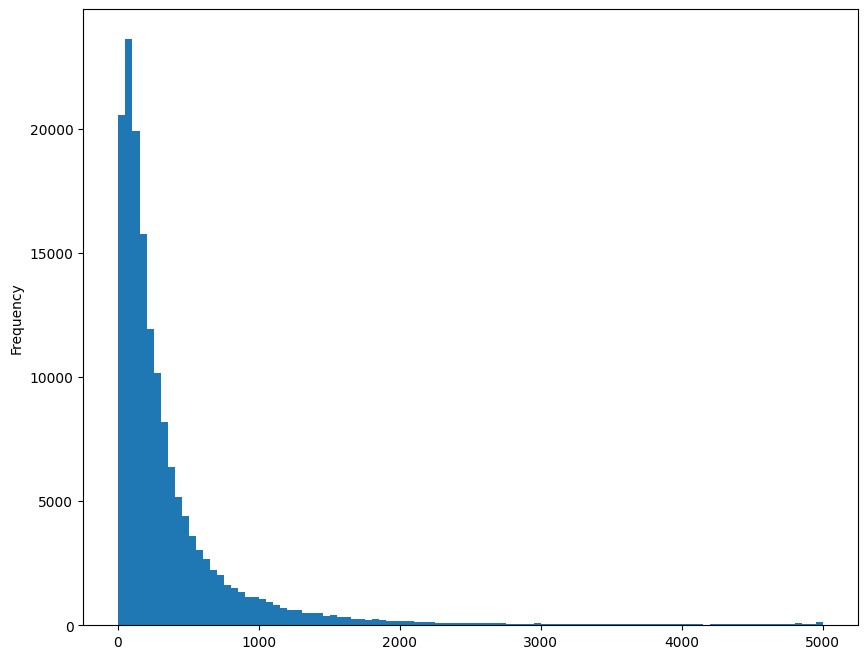

In [9]:
df_train['comment_text'].str.len().plot.hist(bins=100,figsize=(10,8))

In [10]:
df_train['comment_text'].str.len().describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

* Average character lenght in English language range from 5 to 6 characters per word when considering punctuation, spaces, and special characters. This value will vary depending on the specific data source and its characteristics. Average 65-78 words at dataset comment text
* The shortest cooment text is made out of 6 characters, the longest out of 5000 characters
* Average leght of comment texts is 394 characters

## Data preprocess

In [7]:
sentiment_features = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

combined_sentiment = []


for index, row in df_train.iterrows():
    sentiment_list = row[sentiment_features].tolist()
    combined_sentiment.append(sentiment_list)

df_train['labels'] = combined_sentiment

df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


* Target of this project is multilabel, it mean's target label is made out of more than one labels. Because of this 6 toxicity labels are combined into single one.

## Dataset split and format fixing, to be suitible for Trasformers

###  Majority downsample to be ratio 3:1 with minority class

In [12]:
majority_class = df_train[df_train['toxic'] == 0]
minority_class = df_train[df_train['toxic'] == 1]

downsampled_majority = majority_class.sample(n=len(minority_class)+30000, random_state=42)

df_downsampled = pd.concat([downsampled_majority, minority_class])

df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("Class distribution after downsampling:\n", df_downsampled['toxic'].value_counts())

Class distribution after downsampling:
 toxic
0    45294
1    15294
Name: count, dtype: int64


###  Data split to train and validation sets 

In [14]:
X = df_downsampled.drop(
    columns=["labels"]
)
y = df_downsampled["labels"]


In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=df_downsampled["toxic"],
)

In [16]:
y

0        [0, 0, 0, 0, 0, 0]
1        [1, 0, 0, 0, 0, 0]
2        [0, 0, 0, 0, 0, 0]
3        [0, 0, 0, 0, 0, 0]
4        [0, 0, 0, 0, 0, 0]
                ...        
60583    [1, 0, 0, 0, 0, 0]
60584    [0, 0, 0, 0, 0, 0]
60585    [0, 0, 0, 0, 0, 0]
60586    [0, 0, 0, 0, 0, 0]
60587    [1, 0, 0, 0, 0, 0]
Name: labels, Length: 60588, dtype: object

In [17]:
train_df = pd.concat([X_train, y_train.rename("labels")], axis=1)
test_df = pd.concat([X_val, y_val.rename("labels")], axis=1)

In [18]:
print("df_train size:", len(train_df))
print("df_test size:", len(test_df))


df_train size: 48470
df_test size: 12118


###  Validation set labels values counts 

In [19]:
test_df.labels.value_counts()


labels
[0, 0, 0, 0, 0, 0]    8994
[1, 0, 0, 0, 0, 0]    1143
[1, 0, 1, 0, 1, 0]     766
[1, 0, 1, 0, 0, 0]     337
[1, 0, 0, 0, 1, 0]     233
[1, 1, 1, 0, 1, 0]     202
[1, 0, 1, 0, 1, 1]     118
[1, 1, 1, 0, 1, 1]      56
[1, 0, 0, 0, 0, 1]      32
[1, 1, 1, 0, 0, 0]      29
[1, 0, 0, 1, 0, 0]      28
[0, 0, 1, 0, 0, 0]      25
[1, 0, 0, 0, 1, 1]      25
[1, 0, 1, 1, 1, 0]      22
[0, 0, 0, 0, 1, 0]      20
[1, 1, 1, 1, 1, 0]      15
[1, 0, 1, 1, 1, 1]      14
[0, 0, 1, 0, 1, 0]      13
[1, 0, 1, 0, 0, 1]      12
[1, 1, 0, 0, 0, 0]      10
[1, 1, 0, 1, 0, 0]       4
[1, 1, 1, 1, 1, 1]       4
[0, 0, 0, 0, 0, 1]       3
[1, 1, 0, 0, 1, 0]       3
[0, 0, 0, 1, 0, 0]       2
[1, 1, 0, 0, 1, 1]       2
[1, 0, 1, 1, 0, 0]       1
[0, 0, 1, 0, 1, 1]       1
[0, 0, 0, 0, 1, 1]       1
[1, 1, 1, 0, 0, 1]       1
[1, 0, 0, 1, 1, 0]       1
[1, 0, 0, 1, 0, 1]       1
Name: count, dtype: int64

* In training set are multilabel labels which are very rare, some has only one unique labels combination.
* Uncommon labels combinations will be transfered totraining set, so model will learn on those situations more.

###  Minority tranfers

In [20]:
label_counts = test_df["labels"].value_counts()

small_labels = [label for label, count in label_counts.items() if count < 23]

records_to_transfer = test_df[test_df['labels'].apply(lambda x: x in small_labels)]

train_df = pd.concat([train_df, records_to_transfer], ignore_index=True)

test_df.drop(records_to_transfer.index, inplace=True)
print("Updated df_train size:", len(train_df))
print("Updated df_test size:", len(test_df))

Updated df_train size: 48600
Updated df_test size: 11988


In [21]:

test_df.labels.value_counts()


labels
[0, 0, 0, 0, 0, 0]    8994
[1, 0, 0, 0, 0, 0]    1143
[1, 0, 1, 0, 1, 0]     766
[1, 0, 1, 0, 0, 0]     337
[1, 0, 0, 0, 1, 0]     233
[1, 1, 1, 0, 1, 0]     202
[1, 0, 1, 0, 1, 1]     118
[1, 1, 1, 0, 1, 1]      56
[1, 0, 0, 0, 0, 1]      32
[1, 1, 1, 0, 0, 0]      29
[1, 0, 0, 1, 0, 0]      28
[0, 0, 1, 0, 0, 0]      25
[1, 0, 0, 0, 1, 1]      25
Name: count, dtype: int64

In [22]:
test_df.labels.value_counts()

labels
[0, 0, 0, 0, 0, 0]    8994
[1, 0, 0, 0, 0, 0]    1143
[1, 0, 1, 0, 1, 0]     766
[1, 0, 1, 0, 0, 0]     337
[1, 0, 0, 0, 1, 0]     233
[1, 1, 1, 0, 1, 0]     202
[1, 0, 1, 0, 1, 1]     118
[1, 1, 1, 0, 1, 1]      56
[1, 0, 0, 0, 0, 1]      32
[1, 1, 1, 0, 0, 0]      29
[1, 0, 0, 1, 0, 0]      28
[0, 0, 1, 0, 0, 0]      25
[1, 0, 0, 0, 1, 1]      25
Name: count, dtype: int64

## Data from pandas to huggingface DatasetDict
* This way data will be understandable for transformers

In [23]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [24]:
dataset_dict = DatasetDict({
  "train": train_dataset,
  "test": test_dataset
})

### Drop of unussed collumns 

In [25]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'labels'],
        num_rows: 48600
    })
    test: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'labels', '__index_level_0__'],
        num_rows: 11988
    })
})

In [28]:
cols = dataset_dict["train"].column_names
cols.remove("labels")



In [29]:
cols

['id',
 'comment_text',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']

In [32]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 48600
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 11988
    })
})

## Model initialization, tokenization 

In [26]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6,problem_type="multi_label_classification").to('cuda')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* **Model initialized:** Distilbert base uncased
* **Tokenizer :**  AutoTokenizer from pretrained "Distilbert base uncased" model

In [27]:
def tokenize_function(examples):
    return tokenizer(examples["comment_text"], truncation=True, padding="max_length")

* **Tokenization:** Convert text into word or subword units suitable for DistilBERT. This step breaks down text into meaningful units that the model can understand.
* **Truncation :** The truncation=True parameter instructs the tokenizer to shorten sequences if they exceed a predefined maximum length. Max_lenght = 512 tokens. This step addresses the limitation of DistilBERT (All transformers), which can only process sequences up to a specific maximum length.
* **Padding :** padding="max_length" ensures all sequences are padded with special tokens to reach the same length (the maximum length encountered in the batch) for efficient batch processing by the model.

In [31]:
dataset_dict = dataset_dict.map(tokenize_function, batched=True,remove_columns=cols)

Map:   0%|          | 0/48600 [00:00<?, ? examples/s]

Map:   0%|          | 0/11988 [00:00<?, ? examples/s]

In [33]:
dataset_dict.set_format("torch")
dataset_dict = (dataset_dict
          .map(lambda x : {"float_labels": x["labels"].to(torch.float)}, remove_columns=["labels"])
          .rename_column("float_labels", "labels"))

Map:   0%|          | 0/48600 [00:00<?, ? examples/s]

Map:   0%|          | 0/11988 [00:00<?, ? examples/s]

## Model Training

### Training arguments 

In [34]:
lr = 8e-6
bs = 32
epochs = 10

In [35]:


training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=lr,
    lr_scheduler_type='cosine',
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs,
    logging_steps=50,
    fp16=True,
    evaluation_strategy="epoch",
    load_best_model_at_end = True,
    metric_for_best_model = 'roc_auc',
    save_strategy = 'epoch',
    weight_decay=0.1  ,
    
    


)

In [36]:
all_preds = []
all_labels = []

### Trainer evaluation metrics

In [37]:

def multi_labels_metrics(predictions, labels):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    
    
    
    
    y_pred = np.zeros(probs.shape)
    threshold = 0.5
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels

    roc_auc = roc_auc_score(y_true, y_pred, average = 'weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    hamming = hamming_loss(y_true, y_pred)

    metrics = {
        "roc_auc": roc_auc,
        "hamming_loss": hamming,
        "f1": f1
    }
    return metrics

def compute_metrics(p:EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    predictions = preds  

    all_preds.extend(predictions.tolist())  
    all_labels.extend(p.label_ids.tolist())
    result = multi_labels_metrics(predictions=preds,
                                labels=p.label_ids)

    return result

## Trainer training and evaluation 

In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Roc Auc,Hamming Loss,F1,Runtime,Samples Per Second,Steps Per Second
1,0.095400,0.085086,0.887911,0.032658,0.791193,105.361700,113.779000,0.892000
2,0.085800,0.073163,0.900449,0.029099,0.827967,105.508500,113.621000,0.891000
3,0.071400,0.071572,0.906839,0.029516,0.832615,105.737200,113.375000,0.889000
4,0.065600,0.071948,0.908565,0.029474,0.832386,105.345100,113.797000,0.892000
5,0.061300,0.073653,0.910004,0.029988,0.832118,105.261100,113.888000,0.893000
6,0.060200,0.073496,0.905204,0.029905,0.831289,105.253900,113.896000,0.893000
7,0.058100,0.074671,0.904017,0.030252,0.828712,105.693900,113.422000,0.889000
8,0.049600,0.076127,0.901430,0.029696,0.830304,105.893800,113.208000,0.888000
9,0.045200,0.076532,0.905785,0.030433,0.830102,105.297600,113.849000,0.893000
10,0.053600,0.076423,0.904493,0.030252,0.830111,105.485500,113.646000,0.891000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=7600, training_loss=0.07228782076584665, metrics={'train_runtime': 12345.7453, 'train_samples_per_second': 39.366, 'train_steps_per_second': 0.616, 'total_flos': 6.4383748190208e+16, 'train_loss': 0.07228782076584665, 'epoch': 10.0})

In [40]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.07365307211875916,
 'eval_roc_auc': 0.9100044034056056,
 'eval_hamming_loss': 0.029988321654988322,
 'eval_f1': 0.8321184187496125,
 'eval_runtime': 105.4005,
 'eval_samples_per_second': 113.738,
 'eval_steps_per_second': 0.892,
 'epoch': 10.0}

In [41]:
threshold = 0.5
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(all_preds))

y_pred = np.zeros(probs.shape)
y_pred[np.where(probs>=threshold)] = 1

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn


print(classification_report(all_labels, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.91      0.90     32659
           1       0.58      0.35      0.44      3157
           2       0.84      0.88      0.86     16863
           3       0.44      0.42      0.43       308
           4       0.75      0.82      0.78     15400
           5       0.62      0.46      0.53      2541

   micro avg       0.83      0.84      0.83     70928
   macro avg       0.69      0.64      0.66     70928
weighted avg       0.82      0.84      0.83     70928
 samples avg       0.20      0.21      0.20     70928



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Trainer predictions on validation set

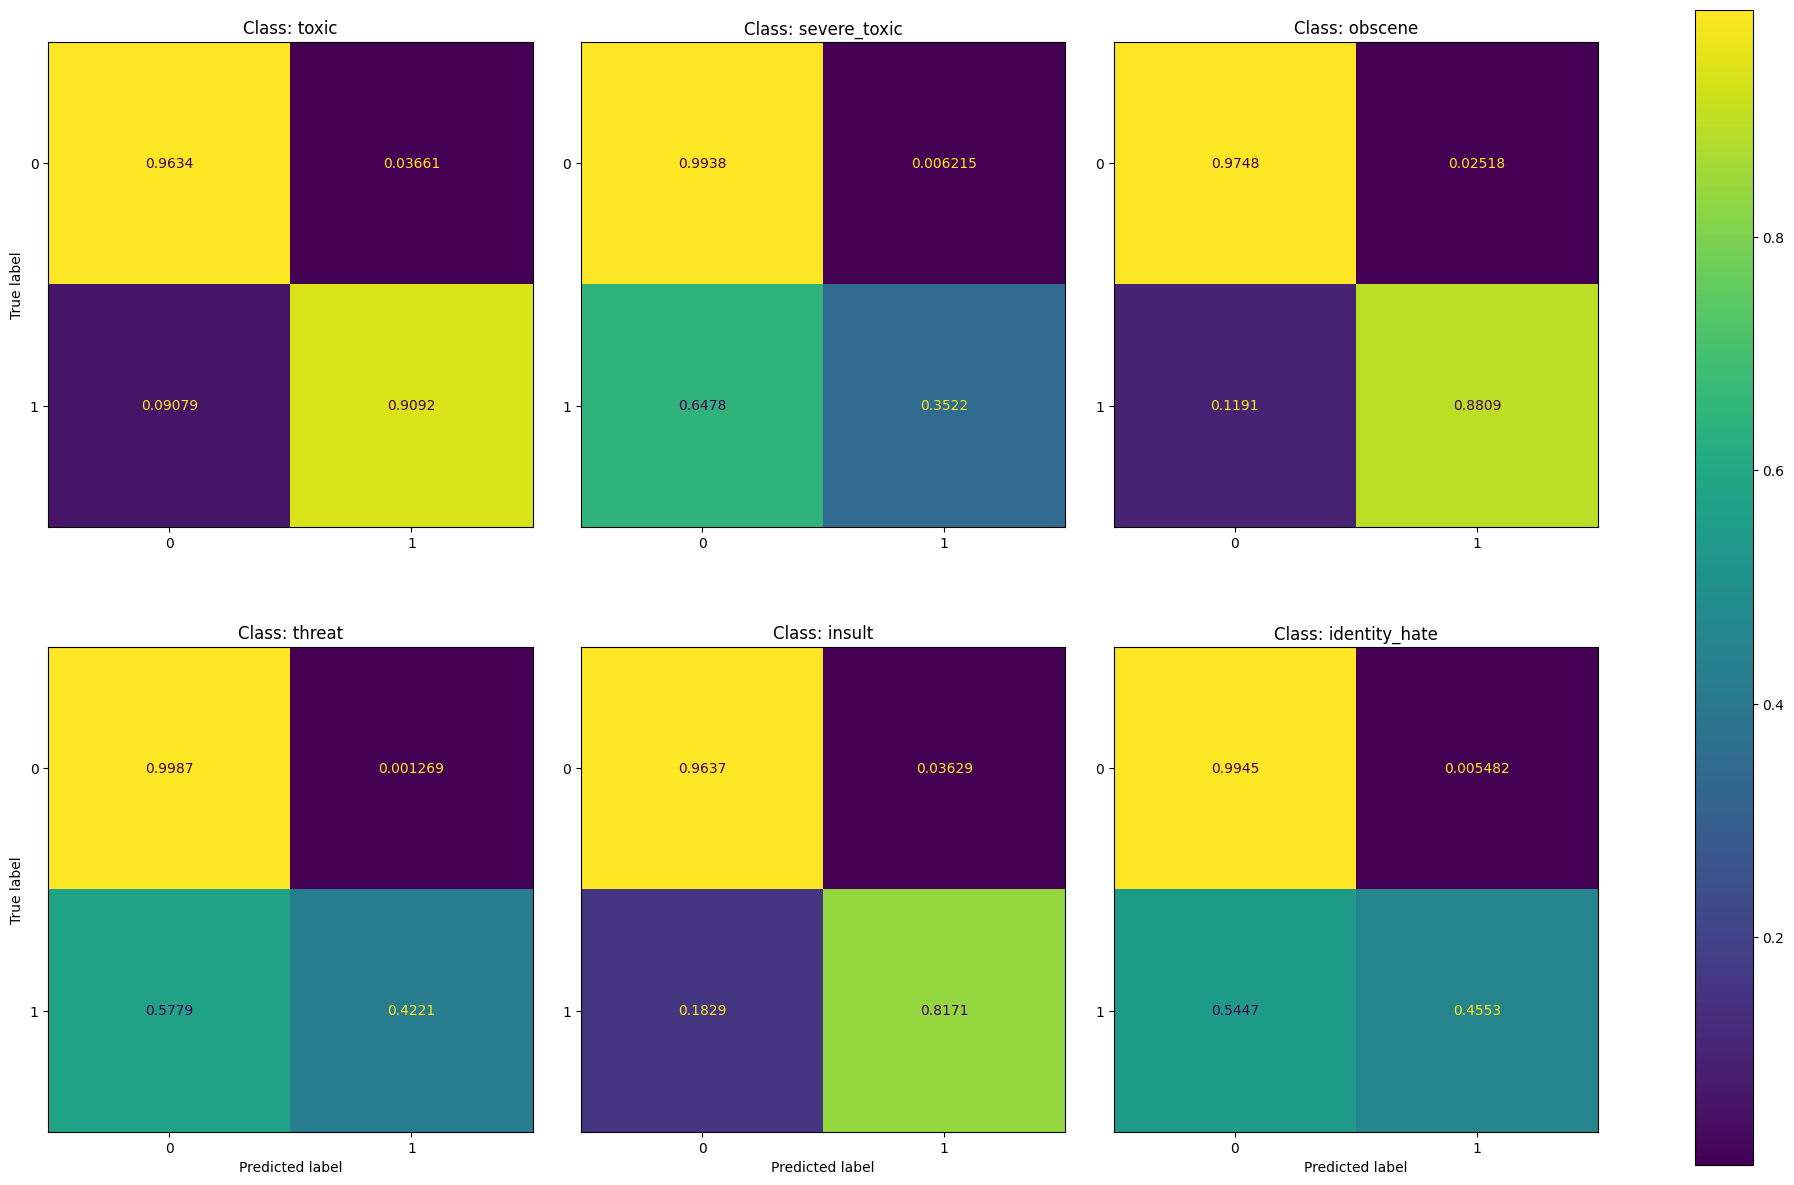

In [43]:
np_all_labels = np.array(all_labels)
np_y_pred = np.array(y_pred)

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()


class_names = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

for i, class_name in enumerate(class_names):
    cm = confusion_matrix(np_all_labels[:, i], np_y_pred[:, i])


    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    disp = ConfusionMatrixDisplay(cm_normalized, display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'Class: {class_name}')
    if i < 3:
        disp.ax_.set_xlabel('')
    if i % 3 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# Model testing

## Test dataset preprocessing

In [44]:
df_test = pd.read_csv(r'/kaggle/working/extracted_files/test.csv')

In [45]:
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


* Test dataset is made out of 153164 records

In [46]:
df_test_labels = pd.read_csv(r'/kaggle/working/extracted_files/test_labels.csv')

In [47]:
df_test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [48]:
df_test_labels.toxic.value_counts()

toxic
-1    89186
 0    57888
 1     6090
Name: count, dtype: int64

In [49]:
merged_test_df = pd.merge(df_test, df_test_labels, on='id')

In [50]:
merged_test_df = merged_test_df[merged_test_df['toxic'] != -1]

In [51]:
merged_test_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [52]:
test_combined_sentiment = []
for index, row in merged_test_df.iterrows():
    sentiment_list = row[sentiment_features].tolist()
    test_combined_sentiment.append(sentiment_list)

merged_test_df['labels'] = test_combined_sentiment

merged_test_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0,"[1, 0, 1, 0, 1, 0]"


In [53]:
testing_dataset = Dataset.from_pandas(merged_test_df)
testing_dataset

Dataset({
    features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'labels', '__index_level_0__'],
    num_rows: 63978
})

In [54]:
cols = testing_dataset.column_names
cols.remove("labels")


In [55]:
testing_dataset = testing_dataset.map(tokenize_function, batched=True,remove_columns=cols)

Map:   0%|          | 0/63978 [00:00<?, ? examples/s]

In [56]:
testing_dataset.set_format("torch")
testing_dataset = (testing_dataset
          .map(lambda x : {"float_labels": x["labels"].to(torch.float)}, remove_columns=["labels"])
          .rename_column("float_labels", "labels"))

Map:   0%|          | 0/63978 [00:00<?, ? examples/s]

In [57]:
testing_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 63978
})

## Model predictions on test data 

In [58]:
predictions = trainer.predict(testing_dataset)


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


### Evaluation metrics of model predictions on a test data 

In [59]:
predictions[2]

{'test_loss': 0.09214481711387634,
 'test_roc_auc': 0.8912378477558198,
 'test_hamming_loss': 0.03595767295007659,
 'test_f1': 0.6433039815795246,
 'test_runtime': 563.5106,
 'test_samples_per_second': 113.535,
 'test_steps_per_second': 0.887}

In [61]:
probs = sigmoid(torch.Tensor(predictions[0]))

y_test_pred = np.zeros(probs.shape)
y_test_pred[np.where(probs>=threshold)] = 1

In [63]:
print(classification_report(predictions[1], np_y_test_pred))

              precision    recall  f1-score   support

           0       0.45      0.96      0.61      6090
           1       0.42      0.42      0.42       367
           2       0.57      0.85      0.68      3691
           3       0.52      0.45      0.48       211
           4       0.62      0.79      0.69      3427
           5       0.67      0.57      0.62       712

   micro avg       0.51      0.85      0.64     14498
   macro avg       0.54      0.67      0.58     14498
weighted avg       0.53      0.85      0.64     14498
 samples avg       0.08      0.08      0.08     14498



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* Model has high weighted recall (0.85) , it identifies 85% of all toxic comments as toxic
* Model has  weighted precision of 0.53, it predict's only 53% of positive class correct. It isn't bad when considering that negative class instances are more than 10 more.

### Confusion matrix of model predictions on a test data

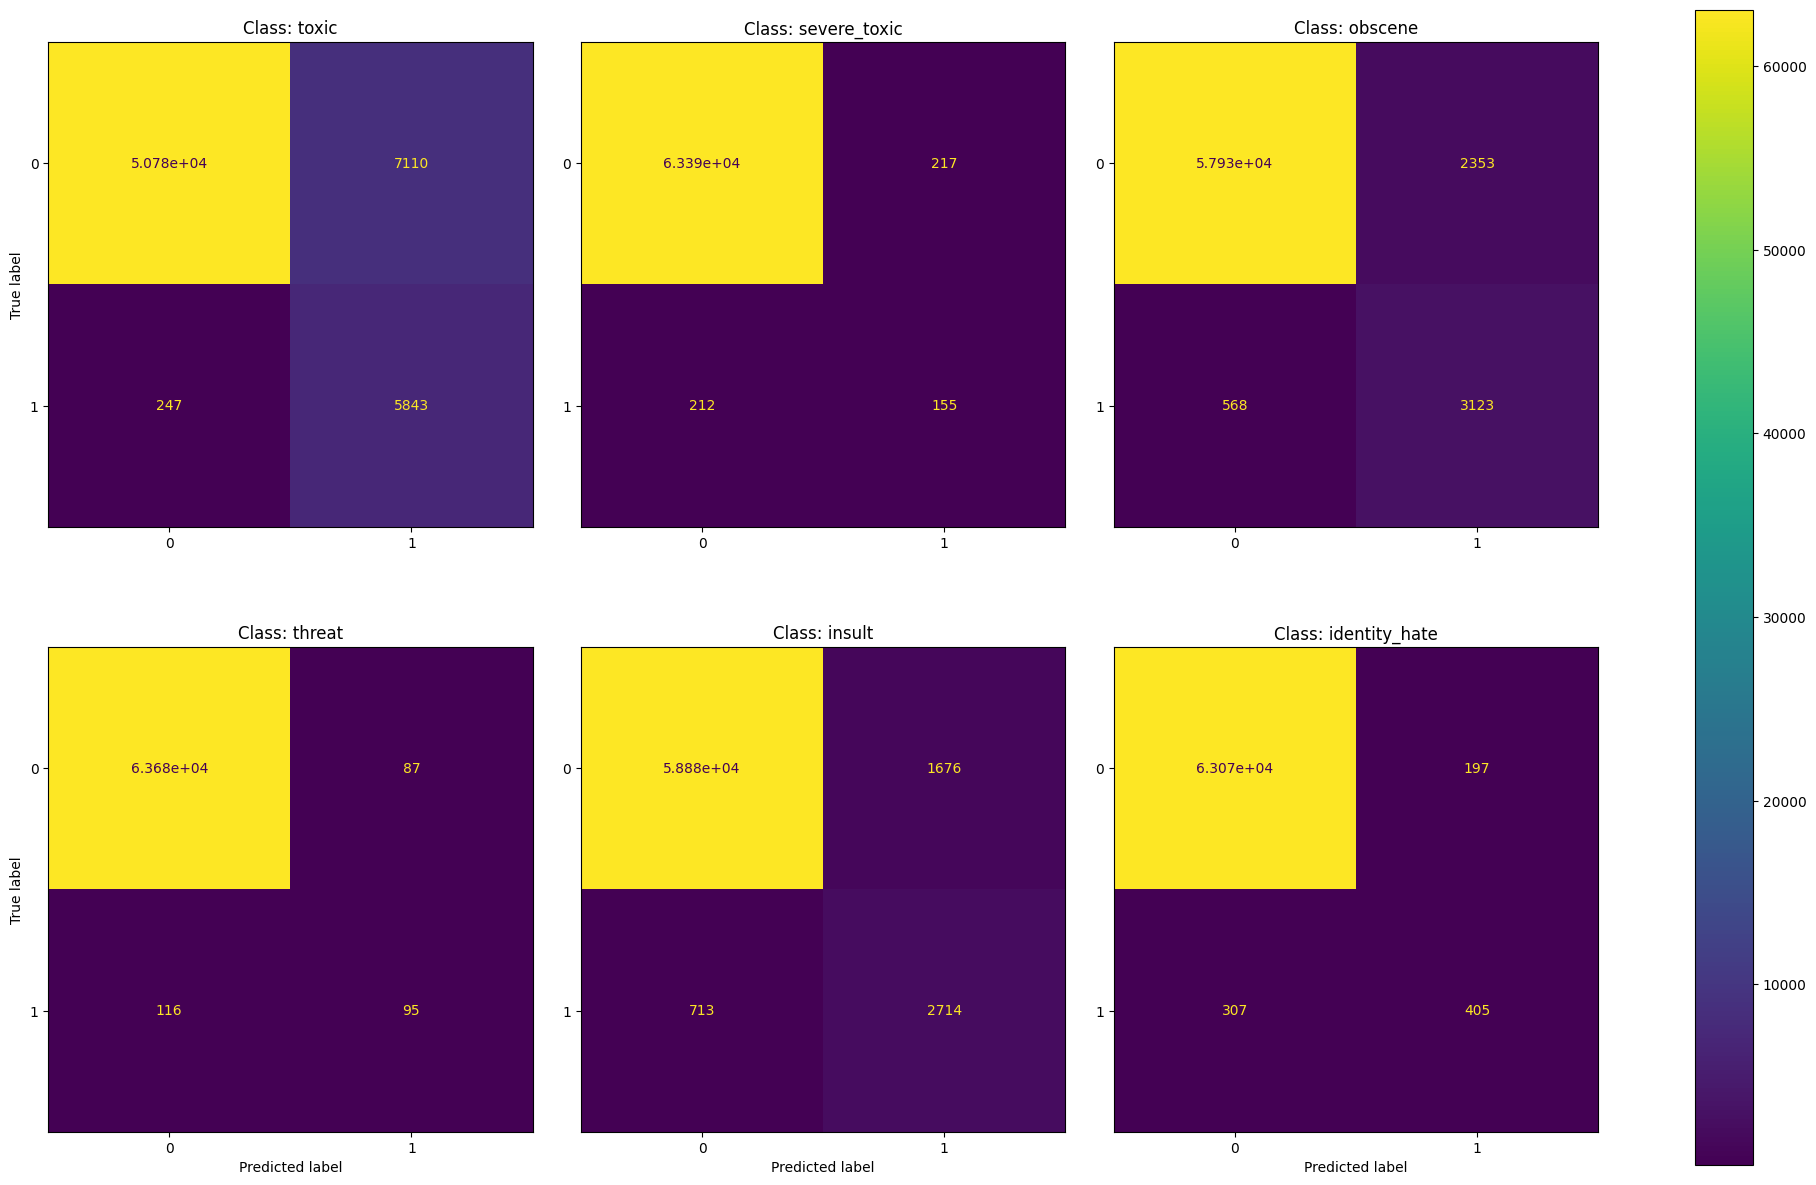

In [62]:
np_y_test_pred = np.array(y_test_pred)

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()


for i, class_name in enumerate(class_names):
    cm = confusion_matrix(predictions[1][:, i], np_y_test_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'Class: {class_name}')
    if i < 3:
        disp.ax_.set_xlabel('')
    if i % 3 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()


# Save of model an it's artefacts

In [66]:
model = trainer.model 
model.save_pretrained("/kaggle/working/model")

In [67]:
tokenizer = trainer.tokenizer  
tokenizer.save_pretrained("/kaggle/working/tokenizer")

('/kaggle/working/tokenizer/tokenizer_config.json',
 '/kaggle/working/tokenizer/special_tokens_map.json',
 '/kaggle/working/tokenizer/vocab.txt',
 '/kaggle/working/tokenizer/added_tokens.json',
 '/kaggle/working/tokenizer/tokenizer.json')

# Conclusion
## Model Performance on test data
* **Test Roc_auc:**  0.8912378477558198
* **Test F1:**  0.6433039815795246
* **Test Hamming_loss:** 0.03595767295007659
* **Test Samples per second:**  113.535
* **Test Weighted recall':**  0.85
* **Test Weighted precision:**  0.53